In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import os


main_path = os.path.split(os.getcwd())[0]
config_path = main_path + '/config.csv'
config_data = pd.read_csv(config_path, sep=',', header=None, index_col=0)

results_path  = config_data.loc['results_dir'][1]


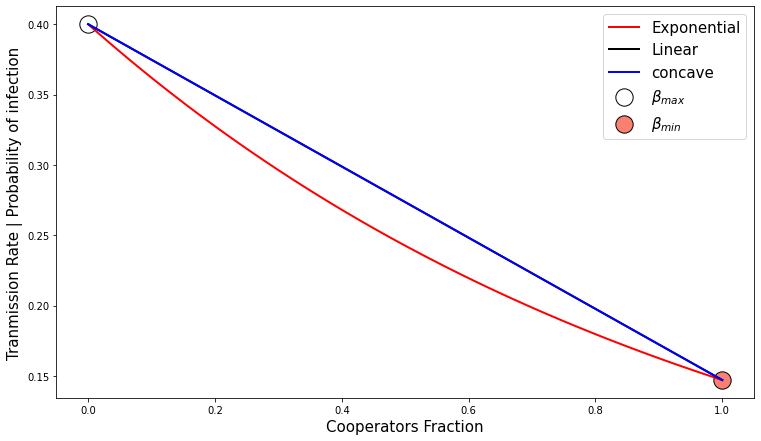

In [6]:

def beta_cooperation_exp(beta_max, coop_frac, type_response="exponential"):

    if type_response=="exponential":
        beta = beta_max*np.exp(-coop_frac)
    elif type_response=="linear":
        beta = beta_max*(1-coop_frac)  + np.exp(-1)*beta_max*coop_frac
    elif type_response=="concave":
        beta2 =  beta_max*np.exp(-coop_frac) - beta_max*(1-coop_frac)  - np.exp(-1)*beta_max*coop_frac
        beta  = beta2

    return beta

coop_frac_vec = np.linspace(0, 1, 100)

beta_max = 0.4
betas_exp    = [beta_cooperation_exp(beta_max, c, type_response="exponential") for c in coop_frac_vec]
betas_linear = [beta_cooperation_exp(beta_max, c, type_response="linear") for c in coop_frac_vec]
betas_conc = [beta_cooperation_exp(beta_max, c, type_response="concave") for c in coop_frac_vec]


fig, ax = plt.subplots(1, 1, figsize=(12.5, 7.2))

ax.plot(coop_frac_vec, betas_exp, label="Exponential", linewidth=2, color="red")
ax.plot(coop_frac_vec, betas_linear, label="Linear", linewidth=2, color="k")
ax.plot(coop_frac_vec, betas_linear, label="concave", linewidth=2, color="blue")

ax.scatter(0, beta_max, edgecolor='k', facecolor='w', s = 300, label=r"$\beta_{max}$")
ax.scatter(1, beta_max * np.exp(-1), edgecolor='k', facecolor='salmon', s = 300, label=r"$\beta_{min}$")

ax.set_ylabel("Tranmission Rate | Probability of infection", fontsize=15)
ax.set_xlabel("Cooperators Fraction", fontsize=15)
ax.legend(fontsize=15)



In [16]:

def beta_cooperation_exp(beta_max, coop_frac, type_response="exponential"):

    if type_response=="exponential":
        beta = beta_max*np.exp(-coop_frac)
    elif type_response=="linear":
        beta = beta_max*(1-coop_frac)  + np.exp(-1)*beta_max*coop_frac
    elif type_response=="concave":
        beta2 =  beta_max*np.exp(-coop_frac) - beta_max*(1-coop_frac)  - np.exp(-1)*beta_max*coop_frac
        beta  = beta2

    return beta

def SIS_replicator(x, t, beta_max, sigma, gamma, type_response="exponential"):
    global N

    S, I, xc, xd = x

    xr = [xc, xd]
    #beta = beta_max*np.exp(-xr[0])
    beta = beta_cooperation_exp(beta_max, xc, type_response=type_response)
    dS = -beta*S*I + gamma*I
    dI =  beta*S*I - gamma*I
    xdotSIS = [dS, dI]

    # Prisoner's dilemma
    S_ = -0.5
    T_ = 1.5
    # Payoff matrix
    sigma_infection = sigma*I

    A = np.array([[1, S_],
                  [T_-sigma_infection, 0-sigma_infection]])/3

    xdotREP = xr*(np.matmul(A,xr) - np.matmul(xr,np.matmul(A,xr)))

    dxdt = [xdotSIS[0], xdotSIS[1], xdotREP[0], xdotREP[1]]

    return dxdt


def run_sims_SIS_replicator(sigma, prob_infect, type_response="exponential"):
    defectFract = 0.5
    coopFract = 0.5
    N = 5000
    S = N-1
    I = 1
    C = coopFract
    D = defectFract



    y0 = [S/N, I/N, C, D]

    t_max = 150
    t = np.linspace(0, t_max, t_max*2)

    gamma = 1/7

    y = odeint(SIS_replicator, y0, t, args=(prob_infect, sigma, gamma, type_response))
    S_ = y[:,0]
    I_ = y[:,1]
    C_ = y[:,2]
    D_ = y[:,3]

    pd_var = pd.DataFrame(columns=['time', 'sigma', 'beta', 'S', 'I', 'C', 'D'])
    pd_var['time'] = t
    pd_var['sigma'] = sigma
    pd_var['beta'] = prob_infect
    pd_var['S'] = S_
    pd_var['I'] = I_
    pd_var['C'] = C_
    pd_var['D'] = D_

    return pd_var


In [20]:
### Save results

t_max = 150
t = np.linspace(0, t_max, t_max*2)
sigma_search = list(np.arange(0, 1,0.1))+[1]
beta_search  = list(np.arange(0, 1,0.1))+[1]

from tqdm import tqdm

for idx_p, prob in enumerate(tqdm(beta_search)):
    for idx_s, sigma in enumerate(sigma_search):

        pd_var_res = run_sims_SIS_replicator(sigma, prob, type_response="exponential")
        pd_var_res_ = pd_var_res.copy()

        if not os.path.isdir( os.path.join(results_path, 'ode_results') ):
            os.makedirs(os.path.join(results_path, 'ode_results'))

        pd_var_res_.to_csv(os.path.join(results_path, 'ode_results', "exponential", 'ode_replicator_sigma_{:0.2f}_beta_{:0.2f}.csv'.format(sigma,prob)))

100%|██████████| 11/11 [00:03<00:00,  3.23it/s]


In [21]:
### Save results

t_max = 150
t = np.linspace(0, t_max, t_max*2)
sigma_search = list(np.arange(0, 1,0.1))+[1]
beta_search  = list(np.arange(0, 1,0.1))+[1]

from tqdm import tqdm

for idx_p, prob in enumerate(tqdm(beta_search)):
    for idx_s, sigma in enumerate(sigma_search):

        pd_var_res = run_sims_SIS_replicator(sigma, prob, type_response="linear")
        pd_var_res_ = pd_var_res.copy()

        if not os.path.isdir( os.path.join(results_path, 'ode_results') ):
            os.makedirs(os.path.join(results_path, 'ode_results'))

        pd_var_res_.to_csv(os.path.join(results_path, 'ode_results', "linear", 'ode_replicator_sigma_{:0.2f}_beta_{:0.2f}.csv'.format(sigma,prob)))

100%|██████████| 11/11 [00:03<00:00,  2.92it/s]
